# Training Deep Neural Networks

Training a deep neural network comes with some problems that one can run into:

- Tricky `vanishing gradients problem` or the related `exploding gradients problem`. This is when the gradients grow smaller and smaller, or larger and larger, when flowing backward through the DNN during training. Both of these problems make lower layers very hard to train.

- Not having enough training data for such a large network, or it might be too costly to label.

- Training may be extremely slow.

- A model with millions of parameters would severely risk overfitting the training set, especially if there are not enough training instances or if they are too noisy.

In this chapter we will go through each of these problems and present techniques to solve them.

## The Vanishing/Exploding Gradients Problems

gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the `Gradient Descent` update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. This is called the `vanishing gradients problem`. In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the `exploding gradients problem`, which surfaces most often in `recurrent neural networks`. More generally, deep neural networks suffer from *unstable gradients*; different layers may learn at widely different speeds.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

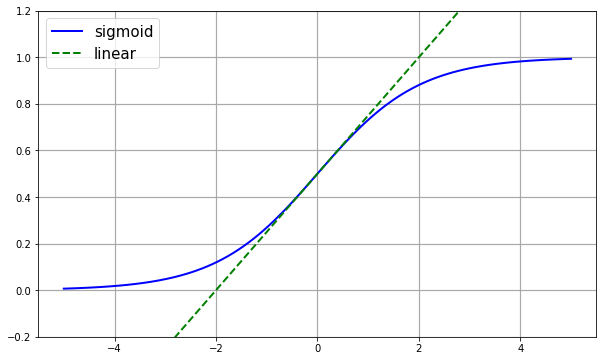

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# plot sigmoid

z = np.linspace(-5, 5, 100)

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(z, sigmoid(z), color='blue', linestyle='-', label='sigmoid', linewidth=2)
ax.plot(z, 1/2 + z/4, color='green', linestyle='--', label='linear', linewidth=2)

ax.grid(linewidth=1.2, color='darkgrey')
ax.legend(fontsize=15)

plt.ylim(-0.2, 1.2)

plt.show()

Looking at the `sigmoid` ($ \mathbf{sigmoid} (z) = 1 / (1+e^{-z})$) activation function above, we can see that when inputs become large (negative or positive), the function saturates at $0$ or $1$, with a derivative extremely close to $0$ (i.e., the curve is almost flat at both extremes). Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

### Glorot and He Initialization

**Glorot initialization (when using the sigmoid activation function):**
$$ \text{Normal distribution with mean } 0 \text{ and variance } \sigma^2 = \frac{1}{fan_{\mathbf{avg}}} $$
$$ \text{Uniform distribution between } -r \text{ and } r, \text{ with } r = \sqrt{\frac{3}{fan_{\mathbf{avg}}}} $$
where $fan_{\mathbf{avg}} = (fan_{\mathbf{in}} + fan_{\mathbf{out}})/2$. This initialization strategy is called `Xavier initialization` or `Glorot initialization`. 

Some papers⁠ have provided similar strategies for different activation functions. These strategies differ only by the scale of the variance and whether they use $fan_{\mathbf{avg}}$ or $fan_{\mathbf{in}}$, as shown in the Table (for the uniform distribution, use $ r = \sqrt{3\sigma^2}$). The initialization strategy for the `ReLU` activation function and its variants is called `He initialization` or `Kaiming initialization`. For `SELU`, use `Yann LeCun`’s initialization method, preferably with a Normal distribution.

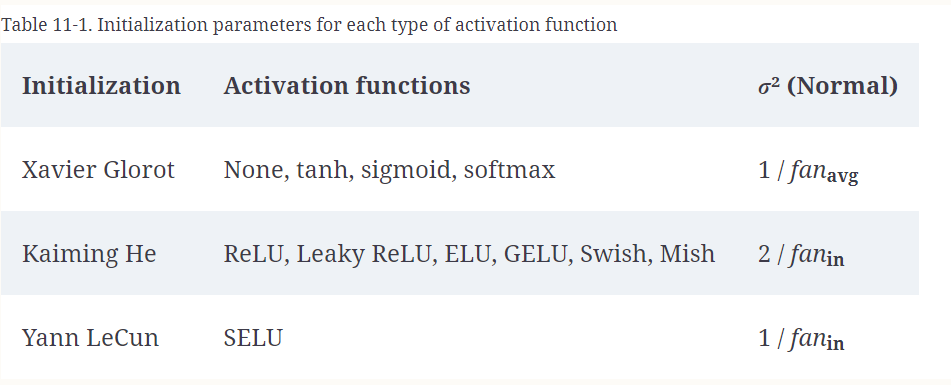

In [3]:
from IPython.display import Image
Image(filename='./images/mls4_table.png')

By default, Keras uses `Glorot initialization` with a uniform distribution. When creating a layer, we can change this to He initialization by setting `kernel_initializer="he_uniform"` or `kernel_initializer="he_normal"`. Alternatively, we can obtain any of the initializations listed in the above Table and more using the `VarianceScaling` initializer. For example, if we want `He initialization` with a uniform distribution and based on $fan_{\mathbf{avg}}$ (rather than $fan_{\mathbf{in}}$), we can use the following code:

In [4]:
import tensorflow as tf

he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

c:\Users\16044\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Better Activation Functions

`ReLU` ($\mathbf{ReLU} (z) = \mathrm{max} (0, z)$) is a better activation function than `sigmoid`, mostly because it does not saturate for positive values, and also because it is very fast to compute. Unfortunately, the `ReLU` activation function is not perfect. It suffers from a problem known as the `dying ReLUs`: during training, some neurons effectively “die,” meaning they stop outputting anything other than 0. This is because the inputs in those neurons are negative. When this happens, Gradient Descent does not affect it anymore because the gradient of the `ReLU` function is zero when its input is negative.

#### Leaky ReLU

To solve this problem, we can use a variant of the `ReLU` function, such as the `leaky ReLU`: $$ \mathbf{LeakyReLU}_{\alpha} (z) = \mathrm{max} (\alpha z, z) $$

The hyperparameter $\alpha$ defines how much the function “leaks”: it is the slope of the function for $z < 0$. Having a slope for $z < 0$ ensures that `leaky ReLUs` never die.⁠

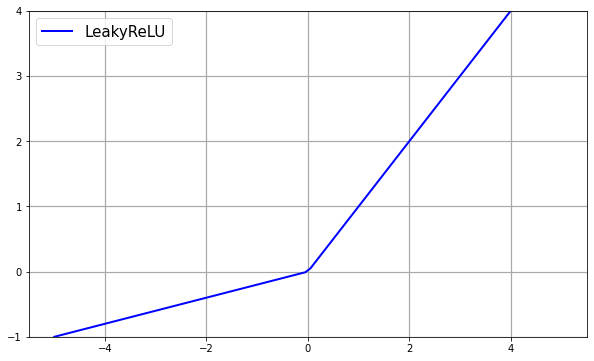

In [5]:
def LeakyReLU(z, alpha):
    return np.maximum(alpha*z, z)

z = np.linspace(-5, 5, 100)

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(z, LeakyReLU(z, 0.2), color='blue', linestyle='-', label='LeakyReLU', linewidth=2)

ax.grid(linewidth=1.2, color='darkgrey')
ax.legend(fontsize=15)

plt.ylim(-1, 4)

plt.show()

There are some variants of `Leaky ReLU` namely `randomized leaky ReLU (RReLU)`, where $\alpha$ is picked randomly in a given range during training and is fixed to an average value during testing. The other variant is `parametric leaky ReLU (PReLU)`, where $\alpha$ is authorized to be learned during training.

Keras includes the classes `LeakyReLU` and `PReLU` in the `tf.keras.layers` package. Just like for other `ReLU` variants, `He initialization`, should be used.

In [6]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3

dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

`ReLU`, `Leaky ReLU`, and `PReLU` all suffer from the fact that they are not *smooth* functions: their derivatives abruptly change (at $z = 0$). This sort of discontinuity can make `Gradient Descent` *bounce* around the optimum, and slow down convergence. So now we will look at *smooth* variants of the `ReLU` activation function, starting with `ELU` and `SELU`.

#### ELU and SELU

**ELU activation function:** $$ \mathbf{ELU}_{\alpha} (z) = \begin{cases} \alpha (e^z -1 ) & \text{ if } z < 0 \\ z & \text{ if } z\ge 0 \end{cases}  $$

The `ELU` activation function looks a lot like the `ReLU` function, with a few major differences:

- It takes on negative values when $z < 0$, which allows the unit to have an average output closer to $0$ and helps alleviate the vanishing gradients problem. The hyperparameter $\alpha$ defines the opposite of the value that the `ELU` function approaches when $z$ is a large negative number. It is usually set to $1$, but can be tweaked like any hyperparameter.

- It has a nonzero gradient for $z < 0$, which avoids the dead neurons problem.

- If $\alpha = 1 $ then the function is smooth everywhere, including around $z = 0$, which helps speed up Gradient Descent since it does not bounce as much to the left and right of $z = 0$.

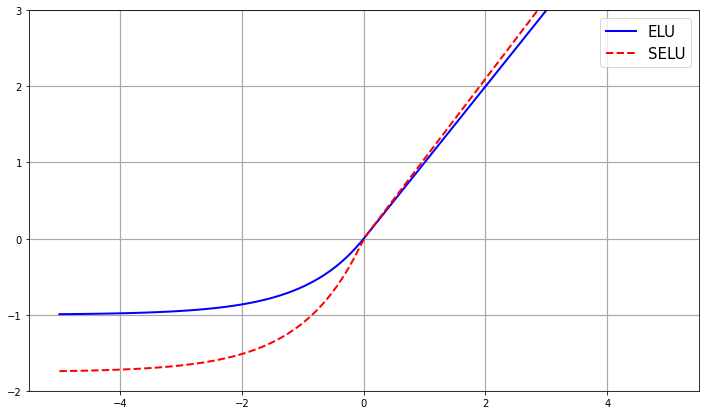

In [7]:
def ELU(z, alpha):
    if z<0:
        return alpha * (np.exp(z)-1)
    else: 
        return z

def SELU(z):
    return 1.05 * ELU(z, 1.67)

z = np.linspace(-5, 5, 100)
elu = [ELU(x, 1.) for x in z]
selu = [SELU(x) for x in z]


fig, ax = plt.subplots(figsize=(12,7))

ax.plot(z, elu, color='blue', linestyle='-', label='ELU', linewidth=2)
ax.plot(z, selu, color='red', linestyle='--', label='SELU', linewidth=2)

ax.grid(linewidth=1.2, color='darkgrey')
ax.legend(fontsize=15)

plt.ylim(-2, 3)

plt.show()

If we build a neural network composed exclusively of a stack of dense layers (i.e., an MLP), and if all hidden layers use the `SELU` activation function, then the network will *self-normalize*: the output of each layer will tend to preserve a mean of 0 and a standard deviation of 1 during training, which solves the vanishing/exploding gradients problem. As a result, the `SELU` activation function may outperform other activation functions for MLPs, especially deep ones. To use it with Keras, just set `activation="selu"`.

#### GELU, Swish and Mish

**GELU activation function**: $$ \mathbf{GELU} (z) = z\Phi(z),$$ where $\Phi$ is the standard Gaussian cumulative distribution function (CDF).

**Swish activation function**: $$ \mathbf{Swish}_{\beta} (z) = z\sigma (\beta z), $$ where $\sigma$ is the sigmoid function.

**Mish activation function**: $$ \mathbf{Mish} (z) = z\tanh (\mathrm{softplus} (z)), $$ where $\mathrm{softplus} (z) = \log(1+e^z)$. 

Keras supports `GELU` and `Swish` out of the box, just use `activation="gelu"` or `activation="swish"`. However, it does not support `Mish` or the `generalized Swish` activation function yet.

### Batch Normalization

Although using He initialization along with ReLU (or any of its variants) can significantly reduce the danger of the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training. *Batch Normalization* (BN) simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs.

**Batch Normalization algorithm**: 
$$ 
\begin{align*} 
\mathbf{\mu}_B &= \frac{1}{m_B} \sum_{i=1}^{m_B} \mathbf{x}^{(i)} \\ 
\mathbf{\sigma}_B^2 &= \frac{1}{m_B} \sum_{i=1}^{m_B} (\mathbf{x}^{(i)} - \mathbf{\mu}_B)^2 \\
\widehat{\mathbf{x}}^{(i)} &= \frac{\mathbf{x}^{(i)} - \mathbf{\mu}_B}{\sqrt{\mathbf{\sigma}_B^2 + \varepsilon}} \\
\mathbf{z}^{(i)} &= \mathbf{\gamma} \otimes \widehat{\mathbf{x}}^{(i)} + \mathbf{\beta} 
\end{align*} 
$$
In this algorithm:
- $\mathbf{\mu}_B$ is the vector of input means, evaluated over the whole mini-batch $B$ (it contains one mean per input).
- $m_B$ is the number of instances in the mini-batch.
- $\mathbf{\sigma}_B$ is the vector of input standard deviations, also evaluated over the whole mini-batch (it contains one standard deviation per input).
- $\widehat{\mathbf{x}}^{(i)}$ is the vector of zero-centered and normalized inputs for instance $i$.
- $\varepsilon$ is a tiny number that avoids division by zero and ensures the gradients don’t grow too large (typically $10^{–5}$). This is called a smoothing term.
- $\gamma$ is the output scale parameter vector for the layer (it contains one scale parameter per input).
- $\otimes$ represents element-wise multiplication (each input is multiplied by its corresponding output scale parameter).
- $\beta$ is the output shift (offset) parameter vector for the layer (it contains one offset parameter per input). Each input is offset by its corresponding shift parameter.
- $\mathbf{z}^{(i)}$ is the output of the BN operation. It is a rescaled and shifted version of the inputs.

#### Implementing Batch Normalization with Keras

As with most things with Keras, implementing `Batch Normalization` is straightforward and intuitive. We just add a `BatchNormalization` layer before or after each hidden layer’s activation function. We may also add a BN layer as the first layer in our model, but a plain `Normalization` layer generally performs just as well in this location.

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In this tiny example with just two hidden layers, `Batch Normalization` is unlikely to have a large impact, but for deeper networks it can make a tremendous difference. Let’s display the model summary:

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               78500     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1

In [11]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

The `BatchNormalization` class has quite a few hyperparameters you can tweak. The defaults will usually be fine, but we may occasionally need to tweak the `momentum`. This hyperparameter is used by the `BatchNormalization` layer when it updates the exponential moving averages; given a new value $\mathbf{v}$ (i.e., a new vector of input means or standard deviations computed over the current batch), the layer updates the running average $\widehat{\mathbf{v}}$ using the following equation: $$ \widehat{\mathbf{v}} \leftarrow \widehat{\mathbf{v}} \times \mathrm{momentum} + \mathbf{v} \times (1-\mathrm{momentum}). $$  
A good momentum value is typically close to $1$; for example, $0.9$, $0.99$, or $0.999$. You want more $9$s for larger datasets and for smaller mini-batches.

Another important hyperparameter is `axis`: it determines which axis should be normalized. It defaults to $–1$, meaning that by default it will normalize the last axis (using the means and standard deviations computed across the other axes).

### Gradient Clipping

Another technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold. This is called `Gradient Clipping`.⁠ This technique is generally used in *recurrent neural networks*, since `Batch Normalization` is tricky to use in *recurrent neural networks* (RNNs), as we will see in Chapter 15.

In Keras, implementing `Gradient Clipping` is just a matter of setting the `clipvalue` or `clipnorm` argument when creating an optimizer, like this:

In [12]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
#model.compile([...], optimizer=optimizer)

## Reusing Pretrained Layers

It is generally not a good idea to train a very large `DNN` from scratch without first trying to find an existing neural network that accomplishes a similar task. If we can find such as neural network, then we can generally reuse most of its layers, except for the top ones. This technique is called *transfer learning*. It will not only speed up training considerably, but also require significantly less training data.

The output layer of the original model should usually be replaced because it is most likely not useful at all for the new task, and it generally does not even have the right number of outputs. Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. One possible approach would be freezing all the reused layers first (i.e., make their weights non-trainable so that Gradient Descent won’t modify them and they will remain fixed), then train the model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves.

### Transfer Learning with Keras